In [9]:
# importing libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import os

In [2]:
# Load labels
df = pd.read_csv('/datasets/faces/labels.csv')

# Create generator
datagen = ImageDataGenerator(rescale=1./255)

# Flow images from dataframe
generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),  # adjust as needed
    batch_size=32,  # adjust as needed
    class_mode='raw'
)

Found 7591 validated image filenames.


In [3]:
# calculating missing values

df.isna().sum()

file_name    0
real_age     0
dtype: int64

No missing values detected.

In [ ]:
# getting an overall impression of the dataset through the age distribution

# Visualize age distribution

plt.figure(figsize=(8, 6))
sns.histplot(df['real_age'], bins=10, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

It seems that the age distribution is skewed to the right, with most people in the dataset being 20-30 years old. Also, ages above 60 are less represented in the dataset.

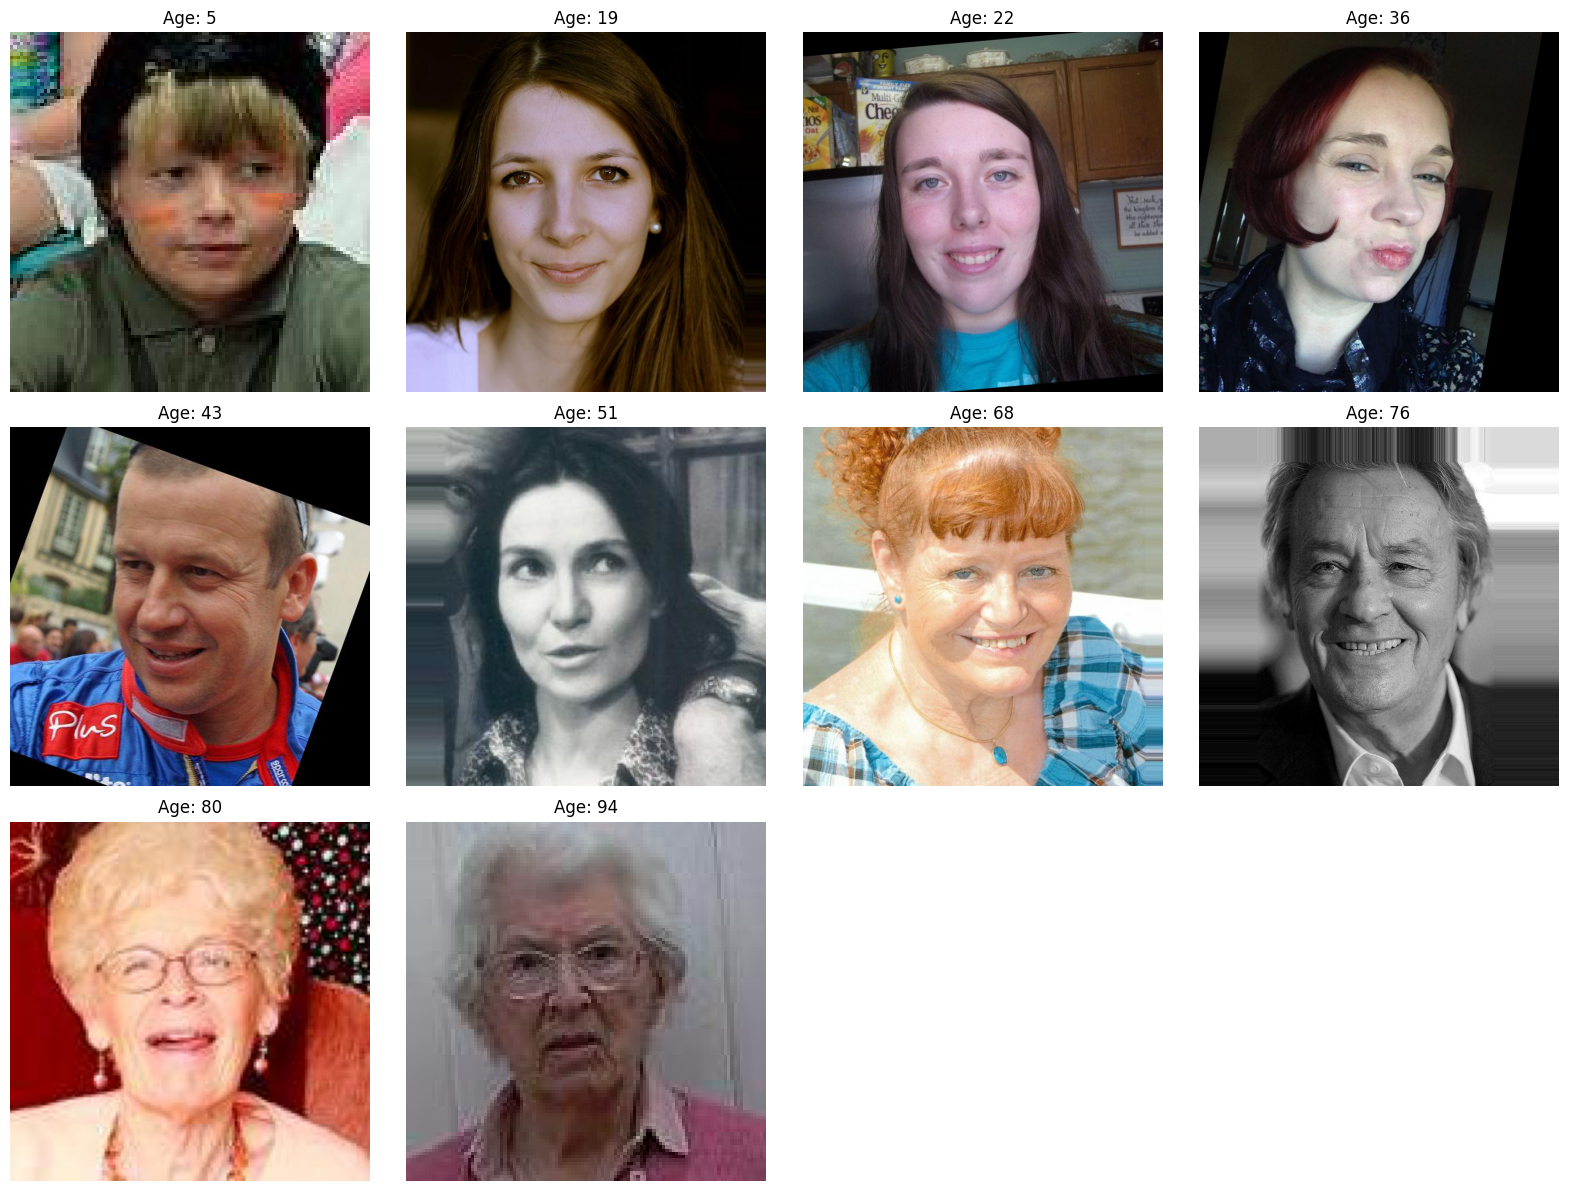

In [5]:
# printing 10-15 photos for different ages 

# Load the labels CSV file
df = pd.read_csv('/datasets/faces/labels.csv')

# Define the directory path to the images
image_dir = '/datasets/faces/final_files/'

# Select a few age groups
age_groups = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

for i, age in enumerate(age_groups):
    age_df = df[(df['real_age'] >= age) & (df['real_age'] < age + 10)]
    if not age_df.empty:
        random_image = age_df.sample(n=1)
        image_path = image_dir + random_image['file_name'].values[0]
        image = mpimg.imread(image_path)
        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.set_title(f'Age: {random_image["real_age"].values[0]}')
        ax.axis('off')
    else:
        ax = axes[i // 4, i % 4]
        ax.axis('off')

# Remove any remaining subplots if not used
for i in range(len(age_groups), 12):
    axes[i // 4, i % 4].axis('off')

plt.tight_layout()
plt.show()

It seems that the images show people of different ages, ranging from 5 - 94 years old. This indicates a diversity in ages across the dataset, with different genders also being represented.

In [6]:
# checking for duplicates

df = df[df.duplicated()]
print(df)

Empty DataFrame
Columns: [file_name, real_age]
Index: []


No duplicates detected. Data seems prepared, now we can move on to analysis.

# Findings 

The dataset contains 7591 file names with no missing values, indicating that this dataset has a good amount of data for training a model. The dataset has a majority group, with 20-30 year olds being more represented than any other age group.

Also, the wide range of ages and the different genders in the dataset is a positive aspect for building a robust model to predict ages from images.

# Modeling 

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load labels
df = pd.read_csv('/datasets/faces/labels.csv')

# Create data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.2
)

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create generators for training and validation sets
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='raw'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='raw'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

# Compile model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)

# Train the model on GPU 
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[early_stopping, reduce_lr]
    )

Found 6072 validated image filenames.
Found 1519 validated image filenames.
94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/50
128/190 [===================>..........] - ETA: 7:31 - loss: 815.7110 - mae: 23.2918

# Training Logs 

Found 6072 validated image filenames. Found 1519 validated image filenames. Epoch 1/50 190/190 [==============================] - 706s 4s/step - loss: 685.3276 - mae: 20.7257 - val_loss: 351.2310 - val_mae: 13.7469 - lr: 1.0000e-04 Epoch 2/50 37/190 [====>.........................] - ETA: 7:45 - loss: 347.7591 - mae: 13.7905

# Conclusions 

In conclusion, the dataset has a good size (7591 images) with a diverse age range (5 - 94 years old) and different genders represented. The age distribution is skewed, with 20-30 year olds being overrepressented and ages above 60 underrepresented.

The model has processed 102/190 batches, with an estimate completion time of around 7 hours